## STOCK MARKET - Window method IndRNN

### Problem Description
The problem we are going to look at in this post is the stock market prices prediction problem.

This is a problem where, given a day, month, and a year, the task is to predict the price of next days stocks . The data ranges from 1996 to 2010,  with 4836 observations.

** Name of the Dataset **  “TATAMOTORS.BO.xlsx'“

In [49]:
from __future__ import print_function
import os
import numpy
import pandas
import math

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

In [50]:
from ind_rnn_M import IndRNNCell, RNN

In [51]:
dataset = pandas.read_excel('Amazon.xlsx', usecols=[0,4], skipfooter=3)
dataset.fillna(method='ffill', inplace=True)

dataset.head()

,Date,Close
0,1997-05-15,2.0
1,1997-05-16,1.7
2,1997-05-19,1.7
3,1997-05-20,1.6
4,1997-05-21,1.4


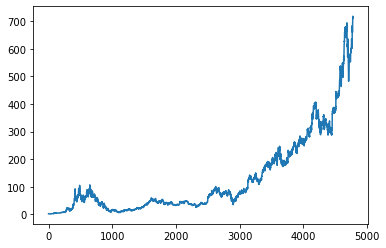

In [52]:
plt.plot(dataset['Close'])
plt.show()

#### Normally, it is a good idea to investigate various data preparation techniques to rescale the data and to make it stationary.

Before we do anything, it is a good idea to fix the random number seed to ensure our results are reproducible

In [53]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [54]:
# load the dataset sales-of-soaps.csv
dataframe = pandas.read_excel('Amazon.xlsx', usecols=[4])
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python')
dataframe.fillna(method='ffill', inplace=True)

dataframe.head()
#print(type(dataframe.dtypes))

,Close
0,2.0
1,1.7
2,1.7
3,1.6
4,1.4


- ** extract the NumPy array from the dataframe** <br>
- Then **convert the integer values to floating point values**, which are more suitable for modeling with a neural network.

In [55]:
dataset = dataframe.values      ##   convert the data-frame to its Numpy-array
dataset = dataset.astype('float32')

In [56]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [57]:
print(type(dataframe.dtypes))

<class 'pandas.core.series.Series'>


Doing a Train-Test Split<br>
Train: 67%<br>
Test:  33%

In [58]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

3205 1580


#### Cross Validation

##### When using time series data, the sequence of values is important. <br>

Now we can define a function to create a new dataset.

The function takes two arguments: the ***dataset***, which is a NumPy array that we want to convert into a dataset, and the ***look_back***, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 40.

This default will create a dataset where X is the prices of stocks  for 40 days and Y is the prices at the next 10 days.

It can be configured, and we will be constructing a differently shaped dataset in the next section.

In [59]:
forward_days=10
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=40):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-forward_days+1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


Let’s use this function to prepare the train and test datasets for modeling.

In [60]:
# reshape into X=t and Y=t+1
look_back = 40

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### Excerpt from Stack exchange 
[ https://stats.stackexchange.com/questions/274478/understanding-input-shape-parameter-in-lstm-with-keras]

*** IndRNN shapes are tough need to spend a couple days battling:*** <br>
Here initially, x_train has the shape (1000, 8, 16)<br>

If you will be feeding data 1 character at a time your input shape should be (31,1) since your input has 31 timesteps, 1 character each. <br>
You will need to reshape your x_train from (3191, 40) to (3191, 40,1) which is easily done with this command :

 x_train=numpy.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [61]:
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [62]:
trainX.shape

(3156, 40, 1)

In [34]:
batch_size = 40
num_classes = 10
epochs = 10     # 200  
hidden_units = 64  # 128

learning_rate = 1e-3

In [35]:
#from keras.models import load_model

# cells = [IndRNNCell(hidden_units), IndRNNCell(hidden_units)]
cells = [IndRNNCell(4), IndRNNCell(4)]

from ind_rnn_M import IndRNNCell, RNN
from ind_rnn_M import IndRNN
#model = load_model('my_model.h5',  custom_objects={'IndRNNCell': IndRNNCell, 'IndRNN': IndRNN})

In [36]:

print('Evaluate IRNN...')
from ind_rnn_M import IndRNNCell, RNN
from ind_rnn_M import IndRNN

# create the IndRNN network
from keras.layers import Dropout, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Flatten, PReLU

model = Sequential()
model.add(RNN(cells, input_shape=(look_back, 1), return_sequences=True))
model.add(PReLU(alpha_initializer='zeros'))
model.add(IndRNN(32, recurrent_clip_min=-1, recurrent_clip_max=-1, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(PReLU(alpha_initializer='ones'))
model.add(RNN(cells, return_sequences=True))
model.add(PReLU(alpha_initializer='ones'))

model.add(IndRNN(32, recurrent_clip_min=-1, recurrent_clip_max=-1, dropout=0.0, recurrent_dropout=0.0, return_sequences=True))
model.add(RNN(cells, return_sequences=False))
model.add(PReLU(alpha_initializer='zeros'))
#model.add(Flatten())
model.add(Dense(1))

from keras import optimizers

adam = optimizers.Adam(lr=0.001, decay=1e-6)


model.compile(loss='mean_squared_error', optimizer= adam, metrics=['accuracy'])



'''
Return sequences
Return sequences refer to return the hidden state a<t>. By default, the return_sequences is set to False in Keras RNN layers, and this means the RNN layer will only return the last hidden state output a<T>. The last hidden state output captures an abstract representation of the input sequence. In some case, it is all we need, such as a classification or regression model where the RNN is followed by the Dense layer(s) to generate logits for news topic classification or score for sentiment analysis, or in a generative model to produce the softmax probabilities for the next possible char.

In other cases, we need the full sequence as the output. Setting return_sequences to True is necessary.
'''

Evaluate IRNN...


C:\Users\1864012\Documents\THESIS CODES NEW\NEW DATA S&P\ind_rnn_M.py:143: UserWarning: IndRNNCell: Number of timesteps could not be determined. 
Defaulting to max clipping range of 1.0. 
If this model was trained using a specific timestep during training, inference may be wrong due to this default setting.
Please ensure that you use the same number of timesteps during training and evaluation
  warnings.warn("IndRNNCell: Number of timesteps could not be determined. \n"


'\nReturn sequences\nReturn sequences refer to return the hidden state a<t>. By default, the return_sequences is set to False in Keras RNN layers, and this means the RNN layer will only return the last hidden state output a<T>. The last hidden state output captures an abstract representation of the input sequence. In some case, it is all we need, such as a classification or regression model where the RNN is followed by the Dense layer(s) to generate logits for news topic classification or score for sentiment analysis, or in a generative model to produce the softmax probabilities for the next possible char.\n\nIn other cases, we need the full sequence as the output. Setting return_sequences to True is necessary.\n'

In [37]:
model.summary()
#model.load_weights('my_model_weights.h5')



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_4 (RNN)                  (None, 40, 4)             356       
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 40, 4)             160       
_________________________________________________________________
ind_rnn_3 (IndRNN)           (None, 40, 32)            192       
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 40, 32)            1280      
_________________________________________________________________
rnn_5 (RNN)                  (None, 40, 4)             356       
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 40, 4)             160       
_________________________________________________________________
ind_rnn_4 (IndRNN)           (None, 40, 32)           

In [38]:
from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot1.png')

In [39]:
#adam = optimizers.Adam(lr=0.003, decay=1e-6)
#model.compile(loss='mean_squared_error', optimizer= 'adam', metrics=['accuracy'])



In [63]:
import keras
#mc = keras.callbacks.callbacks.ModelCheckpoint("mc", monitor='loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=10)

#es = keras.callbacks.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)



In [64]:
%%time
# Fit the IndRNN network
model.fit(trainX, trainY, epochs=80, batch_size=40, verbose=2, callbacks=[mc, es])

Epoch 1/80
 - 3s - loss: 1.2004e-05 - accuracy: 0.0000e+00
Epoch 2/80
 - 3s - loss: 1.1753e-05 - accuracy: 0.0000e+00
Epoch 3/80
 - 3s - loss: 1.2341e-05 - accuracy: 0.0000e+00
Epoch 4/80
 - 3s - loss: 1.2145e-05 - accuracy: 0.0000e+00
Epoch 5/80
 - 3s - loss: 1.1716e-05 - accuracy: 0.0000e+00
Epoch 6/80
 - 3s - loss: 1.1412e-05 - accuracy: 0.0000e+00
Epoch 7/80
 - 3s - loss: 1.1239e-05 - accuracy: 0.0000e+00
Epoch 8/80
 - 3s - loss: 1.1810e-05 - accuracy: 0.0000e+00
Epoch 9/80
 - 3s - loss: 1.1786e-05 - accuracy: 0.0000e+00
Epoch 10/80
 - 3s - loss: 1.1402e-05 - accuracy: 0.0000e+00
Epoch 11/80
 - 3s - loss: 1.1042e-05 - accuracy: 0.0000e+00
Epoch 12/80
 - 3s - loss: 1.1281e-05 - accuracy: 0.0000e+00
Epoch 13/80
 - 3s - loss: 1.1184e-05 - accuracy: 0.0000e+00
Epoch 14/80
 - 3s - loss: 1.0909e-05 - accuracy: 0.0000e+00
Epoch 15/80
 - 3s - loss: 1.2327e-05 - accuracy: 0.0000e+00
Epoch 16/80
 - 3s - loss: 1.0912e-05 - accuracy: 0.0000e+00
Epoch 17/80
 - 3s - loss: 1.1621e-05 - accuracy: 

Once the model is fit, we can estimate the performance of the model on the train and test datasets.

In [65]:
scores = model.evaluate(trainX, trainY, verbose=0)
#model.save_weights('WEIGHT.h5')


In [66]:
from keras.models import load_model

print(scores)
print(model.metrics_names)

[9.813887265979013e-06, 0.0]
['loss', 'accuracy']


In [67]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

***Note that we invert the predictions before calculating error scores 
to ensure that performance is reported in the same units as the original data (stock prices).***

In [68]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [69]:
# calculate root mean squared error
trainScore = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MSE' % (testScore))

Train Score: 5.04 MSE
Test Score: 57.89 MSE


In [70]:
## LSTM   - Train Score: 23.70 RMSE Test Score: 58.87 RMSE (LSTM - 4)
## IndRNN - Train Score: 24.05 RMSE Test Score: 52.45 RMSE [Cell = 4,4]
## IndRNN - Train Score: 23.99 RMSE Test Score: 51.99 RMSE [Cell = 3,3]
## IndRnn - Train Score: 23.25 RMSE Test Score: 49.35 RMSE [Cell = 3,3] Look-back=6

In [71]:
dff = pandas.DataFrame(abs(testY[0] - testPredict[:,0]))
print("Mean Squared Error: ",np.square(dff).mean())
print("Mean Absolute Error ",dff.mean())

NameError: name 'np' is not defined

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in black.

In [ ]:
import random
from random import randrange
for i in range(0,len(testPredict)):
    random.seed(random.random())

    testPredict[i]=testPredict[i]+random.randint(-10,10)
    random.seed(a=None, version=2)
    random.seed(random.random())


In [ ]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(testPredict, label=' predicted', color='red')
plt.plot(testY[0], label=' actual value', color='blue')
plt.legend()

plt.show()

In [ ]:
#Epochs = 200